# Experiment description
## Hypothesis: 
H1: The amount of contingency increases after removing december and january outliers.

## Method: 
- Remove outliers > q=0.99
- Assign mean values for removed points
- Compare constancy and contingency values with the ones obtained on experiment 4.

## Built-in methods

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import scipy
import math
from math import pi
import geopandas as gpd
%matplotlib inline

In [2]:
def set_initial_dataset_day(df_by_date,name_day):
    df_by_date = df_by_date.reset_index()
    df_by_date['day_of_week'] = df_by_date['date'].dt.day_name()
    monday_idx = df_by_date.index[df_by_date['day_of_week'] == name_day].tolist()[0]
    df_by_date = df_by_date[monday_idx:].set_index('date').drop(['day_of_week'],axis=1)
    return df_by_date

In [3]:
# Methods for time windows
def im2patches(im,n):
    patches = [];
    for i in range(len(im)-n):
        patch = im[i:(i+n-1)]        
        patch = patch - np.nanmean(patch);
        if(np.linalg.norm(patch)>0):
            patch = patch/np.linalg.norm(patch);
        if i==0:
            patches = patch;
        else:
            patches = np.vstack((patches,patch))
    return patches;


def writeEmbeding(timeSeries,lenWindow,samplePath, scenarioName):
    slicingWindows = im2patches(timeSeries,lenWindow);
    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/slicing/'
    prevStation = str(samplePath);
    with open(workingPath+'slicingWindows'+"_"+str(prevStation)+"_"+str(scenarioName)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = slicingWindows.tolist();                        
        pickle.dump(lv, f, protocol=2)

    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/timeSeries/'    
    with open(workingPath+'timeSeries'+"_"+str(prevStation)+"_"+str(scenarioName)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = timeSeries.tolist();                        
        pickle.dump(lv, f, protocol=2)



In [4]:
#Methods for predictability
def getBarcode(samplePath,lenWindow,scenarioName):
    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/'
    barcode = [];

    with open(workingPath+'timeSeries/'+'timeSeries_'+samplePath+"_"+str(scenarioName)+'_'+str(lenWindow)+'_'+'.pickle', 'rb') as f:
            timeSeries = pickle.load(f);            
    return (barcode,timeSeries);

def computeBarcodeEntropy(barsLenB0):
    barlen = np.array(barsLenB0);
    barlen = barlen/barlen.sum();
    hbc = 0;
    for i in range(barlen.shape[0]):
        if barlen[i]!=0:
            hbc = hbc-(barlen[i])*np.log(barlen[i]);
    return hbc;


def computeGeneralPredictability(timeSeries,binsData,lenWindow):
    # Colwell, R. K. (1974). Predictability, constancy, and contingency of periodic phenomena. Ecology, 55(5), 1148-1153.
    # Normalize the caudal values
    nLevels = binsData.shape[0]-1;
    matStations = np.array(timeSeries).reshape((np.array(timeSeries).shape[0]//lenWindow,lenWindow))    

    grandMean = np.mean(np.mean(matStations));
    #matStations = matStations / grandMean;
    N = np.zeros((nLevels,lenWindow));
    for i in range(1,matStations.shape[1]): 
        # Computes histograms per columns
        hist, bin_edges = np.histogram(matStations[:,i],bins = binsData);
        N[:,i] = hist;
    X = np.sum(N, axis=0);
    Y = np.sum(N, axis=1);
    Z = np.sum(Y);
    hx = 0;
    hy = 0;
    hxy = 0;
    for j in range(X.shape[0]):
        if X[j]!=0:
            hx = hx-(X[j]/Z)*np.log(X[j]/Z);
            
    for i in range(Y.shape[0]):
        if Y[i]!=0:
            hy = hy-(Y[i]/Z)*np.log(Y[i]/Z);
            
    for i in range(Y.shape[0]):
        for j in range(X.shape[0]):
            if N[i,j]!=0:
                hxy = hxy-((N[i,j]/Z)*np.log(N[i,j]/Z));    
    
    # predictability
    p = 1 - (hxy - hx)/np.log(N.shape[0]);
    # constancy
    c = 1 - hy/np.log(N.shape[0]);
    # Returns constancy and contingency
    return (c,p-c,p);



In [5]:
def preprocess_df(df):
    #Remove outliers
    q_hi = df["total_eventos"].quantile(0.99)
    df = df[(df["total_eventos"] < q_hi)]
        
    #Make sure dataset starts on Monday for the experiment
    df = set_initial_dataset_day(df,'Monday')

    #Make sure dataset include consecutive dates in period
    idx = pd.date_range(min(df.reset_index().date), max(df.reset_index().date))
    df = df.reindex(idx, fill_value=int(df["total_eventos"].mean()))
    
    return df

In [6]:
def predictability_experiment(df_by_date,lenWindow,localidadesList,Levels,lT):
    #write embeding
    for localidad in localidadesList:
        df_by_localidad = df_by_date[df_by_date['LOCALIDAD'] == localidad]        
        df_by_localidad = preprocess_df(df_by_localidad)        
        df_localidad_values = pd.Series(df_by_localidad['total_eventos']).values
        df_localidad_values = df_localidad_values[0:lT]
        writeEmbeding(df_localidad_values,lenWindow,'aggressiveBehavior',localidad)
    
    #find predictability, constancy and contingency
    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/';

    flagF = True;
    for localidad in localidadesList:        
        for nLevels in Levels:
            for expName in ['aggressiveBehavior']:
            #for expName in ['aggressiveBehavior','random']:
                (barcode,timeSeries) = getBarcode(expName,lenWindow,localidad);
                binsLevels = np.linspace(np.min(timeSeries),np.max(timeSeries),nLevels);
                #print(nLevels)
                #print(localidad)
                c,m,p = computeGeneralPredictability(timeSeries,binsLevels,lenWindow)
                
                if flagF==True:
                    flagF = False
                    predValues = np.array([expName,localidad,lenWindow,nLevels,p,m,c]);
                else:
                    predValues = np.vstack((predValues, [expName,localidad,lenWindow,nLevels,p,m,c]))

    return predValues
        
    

In [7]:
def table_predictability_report(df_agressiveBehavior,lenWindow,localidadesList,levelCategories,name_experiment):
    join=df_agressiveBehavior.pivot('localidad','crime_level','predictability')
    var1_order = []
    var2_order = levelCategories
    if len(var2_order) > 0:
        join = join.reindex(var2_order, axis=1)
    if len(var1_order) > 0:
        join = join.reindex(var1_order)
    
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
    fig.set_size_inches(7, 6)
    g=sns.heatmap(join.astype('float'),annot=True,fmt=".3",linewidths=0,cmap="Blues",cbar=False)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    file_path = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/figures/'
    plt.savefig(file_path+'table_aggressiveBehavior_localidades'+str(name_experiment)+'_predictability_time_'+str(lenWindow)+'_levels_'+str(levelCategories),dpi=300,bbox_inches = "tight")
    plt.show()

In [8]:
def table_constancy_report(df_agressiveBehavior,lenWindow,localidadesList,levelCategories,name_experiment):
    join=df_agressiveBehavior.pivot('localidad','crime_level','constancy')
    var1_order = []
    var2_order = levelCategories
    if len(var2_order) > 0:
        join = join.reindex(var2_order, axis=1)
    if len(var1_order) > 0:
        join = join.reindex(var1_order)
    
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
    fig.set_size_inches(7, 6)
    g=sns.heatmap(join.astype('float'),annot=True,fmt=".3",linewidths=0,cmap="Blues",cbar=False)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    file_path = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/figures/'
    plt.savefig(file_path+'table_aggressiveBehavior_localidades'+str(name_experiment)+'_constancy_time_'+str(lenWindow)+'_levels_'+str(levelCategories),dpi=300,bbox_inches = "tight")
    plt.show()

In [9]:
def table_contingency_report(df_agressiveBehavior,lenWindow,localidadesList,levelCategories,name_experiment):
    join=df_agressiveBehavior.pivot('localidad','crime_level','contingency')
    var1_order = []
    var2_order = levelCategories
    if len(var2_order) > 0:
        join = join.reindex(var2_order, axis=1)
    if len(var1_order) > 0:
        join = join.reindex(var1_order)
    
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
    fig.set_size_inches(7, 6)
    g=sns.heatmap(join.astype('float'),annot=True,fmt=".3",linewidths=0,cmap="Blues",cbar=False)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    file_path = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/figures/'
    plt.savefig(file_path+'table_aggressiveBehavior_localidades'+str(name_experiment)+'_contingency_time_'+str(lenWindow)+'_levels_'+str(levelCategories),dpi=300,bbox_inches = "tight")
    plt.show()

In [40]:
def all_predictability_measures(df,lenWindow,crime_level,name_experiment):
    join=df.pivot('localidad','variable','value')
    var1_order = []
    var2_order = []
    if len(var2_order) > 0:
        join = join.reindex(var2_order, axis=1)
    if len(var1_order) > 0:
        join = join.reindex(var1_order)

    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
    fig.set_size_inches(7, 6)
    g=sns.heatmap(join.astype('float'),annot=True,fmt=".3",linewidths=0,cmap="Blues",cbar=False)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    file_path = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/figures/'
    plt.savefig(file_path+'table_aggressiveBehavior_localidades'+str(name_experiment)+'_predict_measures_time_'+str(lenWindow)+'_crime_'+str(crime_level),dpi=300,bbox_inches = "tight")
    plt.show()

In [10]:
def map_localidad(ax,df,col_localidad,col_vals,vmin=None,vmax=None):
  loc_geo="/Users/anamaria/Desktop/dev/security_project/assets/localidades_polygon.json"
  loc_=gpd.read_file(loc_geo)
  loc_=loc_.merge(df,left_on='LocNombre',right_on=col_localidad)
  loc_.plot(cmap='viridis',column=col_vals,legend=True,ax=ax,vmin=vmin,vmax=vmax)  

In [11]:
def map_predictability(df_crime, crime_level, lenWindow,name_experiment):
    subdata = df_crime[df_crime['crime_level']==crime_level]
    subdata = subdata[subdata['lenWindow']==str(lenWindow)]
    subdata["predictability"] = pd.to_numeric(subdata["predictability"])
    
    fig, ax = plt.subplots(figsize=(12,12))
    map_localidad(ax,subdata,'localidad','predictability')
    ax.axis('off')
    file_path = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/figures/'
    plt.savefig(file_path+'map_aggressiveBehavior_localidades'+str(name_experiment)+'_predictability_time_'+str(lenWindow)+'_levels_'+str(crime_level),dpi=300,bbox_inches = "tight")
    plt.show()

## Load data

In [12]:
data_location = '/Users/anamaria/Desktop/dev/security_project/datasets/verify_enrich_nuse_29112019.csv'
df_input = pd.read_csv(data_location,delimiter=",")

In [13]:
df_input['date']=pd.to_datetime(df_input['FECHA'])
df_by_date = pd.DataFrame(df_input.groupby(['date','LOCALIDAD']).size(),columns=["total_eventos"])

In [14]:
df_by_date = df_by_date.reset_index().set_index('date')

## Experiment to validate H1

In [15]:
Levels=[3,5,10]
levelCategories = list(map(lambda x: str(x), Levels))
localidadesList = list(df_by_date.LOCALIDAD.unique())
localidadesList.remove('SIN LOCALIZACION')
timeWindows = [7, 14, 28, 84]
lT = 756
name_experiment = '_remove_outliers_'

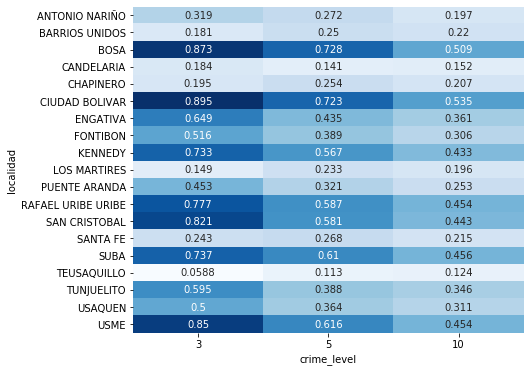

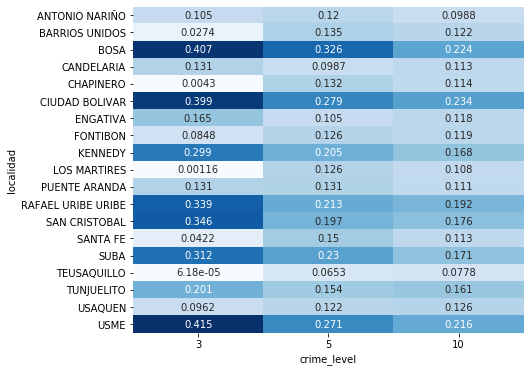

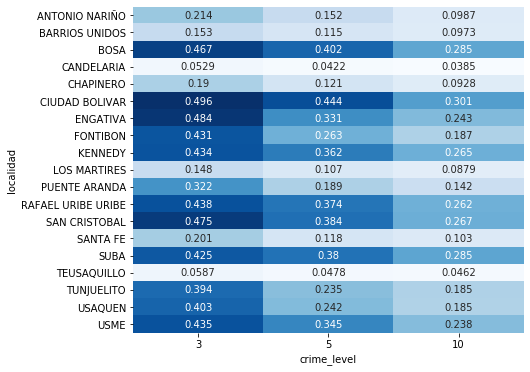

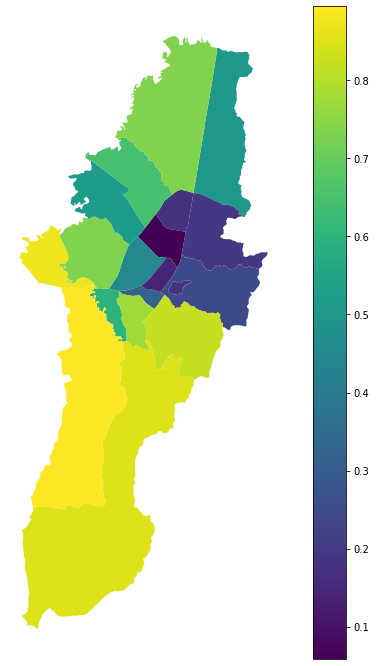

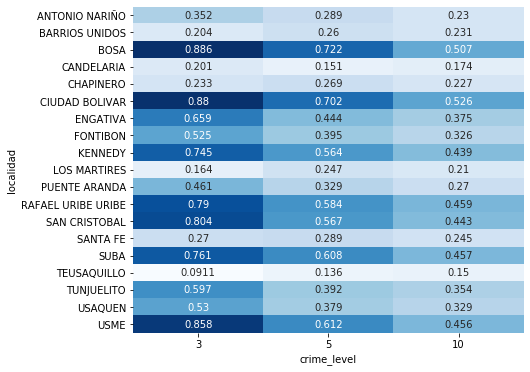

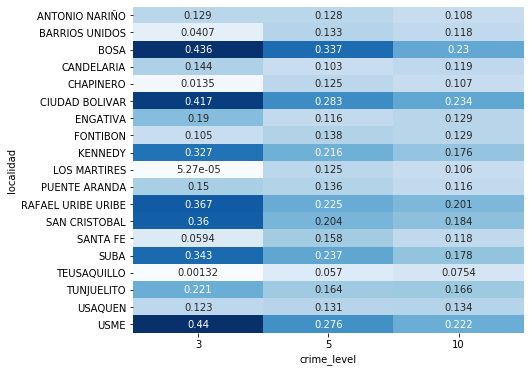

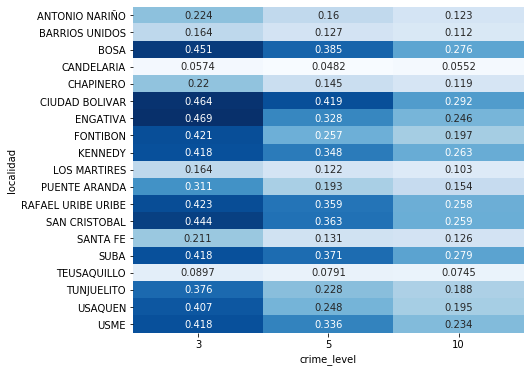

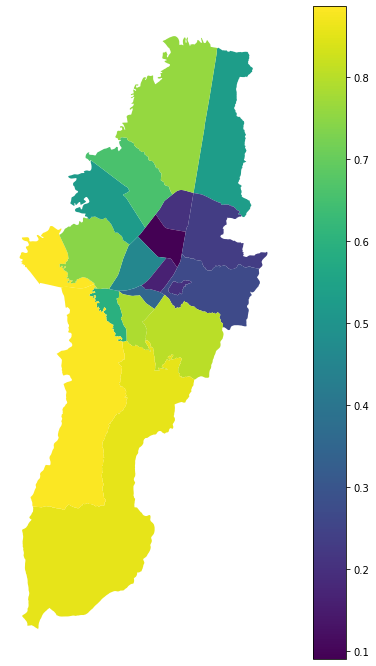

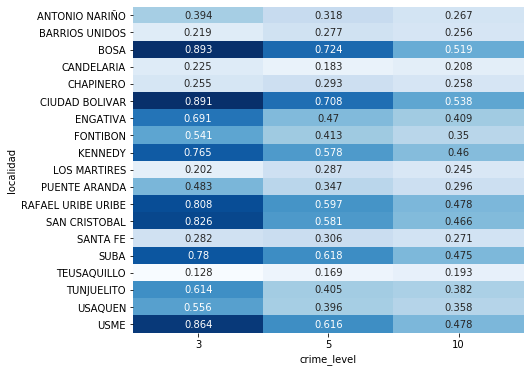

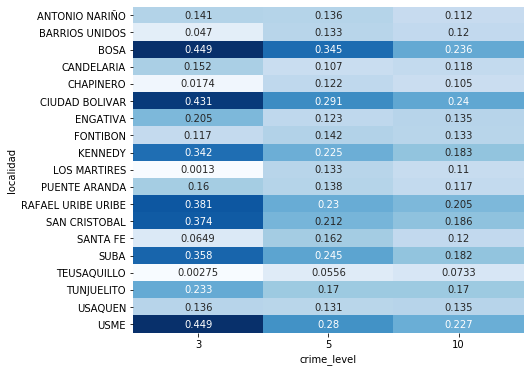

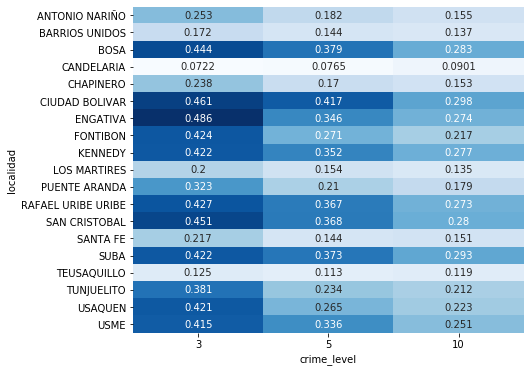

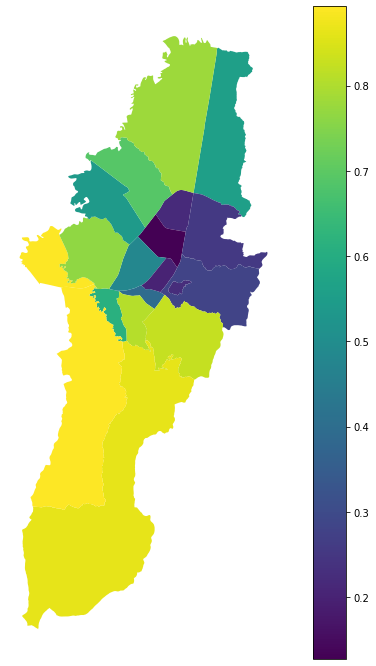

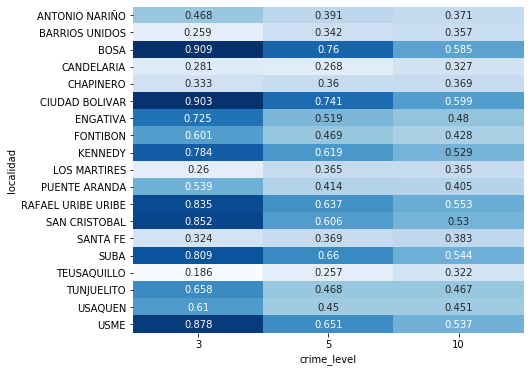

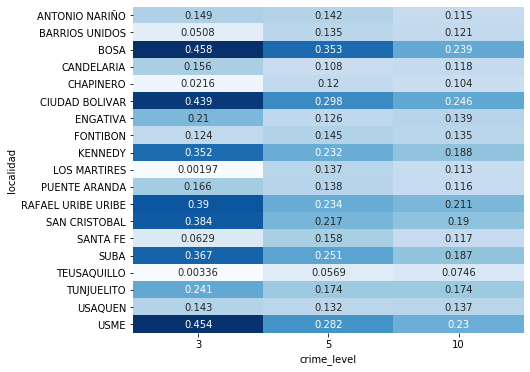

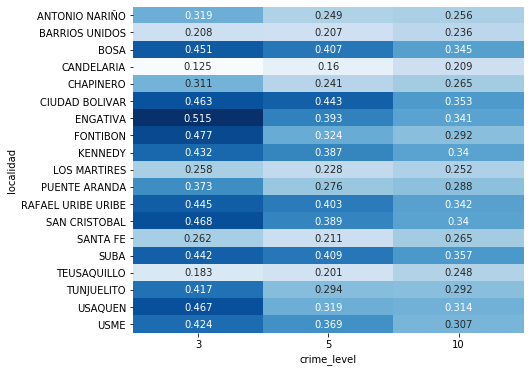

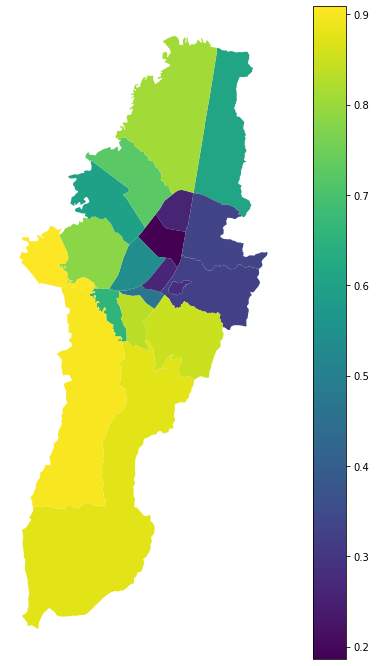

In [16]:
for lenWindow in timeWindows:
    predValues = predictability_experiment(df_by_date,lenWindow,localidadesList,Levels,lT)
    df_prediction = pd.DataFrame(predValues, columns=['crime_type', 'localidad','lenWindow','crime_level','predictability','contingency','constancy'])
    df_agressiveBehavior = df_prediction[df_prediction['crime_type']=='aggressiveBehavior']
    table_predictability_report(df_agressiveBehavior,lenWindow,localidadesList,levelCategories,name_experiment)
    table_constancy_report(df_agressiveBehavior,lenWindow,localidadesList,levelCategories,name_experiment)
    table_contingency_report(df_agressiveBehavior,lenWindow,localidadesList,levelCategories,name_experiment)
    crime_level = '3'
    map_predictability(df_agressiveBehavior, crime_level, lenWindow,name_experiment)

In [ ]:
c_bolivar=df_by_date[df_by_date['LOCALIDAD']=='CIUDAD BOLIVAR']
c_bolivar = preprocess_df(c_bolivar)

In [ ]:
c_bolivar.head(90).plot()

In [ ]:
teusaquillo=df_by_date[df_by_date['LOCALIDAD']=='TEUSAQUILLO']
teusaquillo = preprocess_df(teusaquillo)
teusaquillo.head(90).plot()

## Contribution of complementary measures on predictability

In [21]:
Levels=[3,5,10]
levelCategories = list(map(lambda x: str(x), Levels))
localidadesList = list(df_by_date.LOCALIDAD.unique())
localidadesList.remove('SIN LOCALIZACION')
timeWindows = [7, 14, 28, 84]
lT = 756
name_experiment = '_remove_outliers_'

In [31]:
lenWindow = 7
crime_level = '3'
predValues = predictability_experiment(df_by_date,lenWindow,localidadesList,Levels,lT)
df_prediction = pd.DataFrame(predValues, columns=['crime_type', 'localidad','lenWindow','crime_level','predictability','contingency','constancy'])
df_agressiveBehavior = df_prediction[df_prediction['crime_level']==crime_level]

In [33]:
df_agressiveBehavior.drop(columns=['crime_type','lenWindow','crime_level'],inplace=True)

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,localidad,predictability,contingency,constancy
0,ANTONIO NARIÑO,0.3192592761621601,0.2144178054660466,0.10484147069611349
3,BARRIOS UNIDOS,0.18055157949323775,0.15310389606208064,0.02744768343115711
6,BOSA,0.8731482226477267,0.46652805898938565,0.4066201636583411
9,CANDELARIA,0.18400080457620693,0.05288147482223848,0.13111932975396845
12,CHAPINERO,0.19477313047758438,0.19047414179986033,0.004298988677724047
15,CIUDAD BOLIVAR,0.8946228210557372,0.4959013603119159,0.3987214607438213
18,ENGATIVA,0.6494201259971504,0.4842534727963709,0.1651666532007795
21,FONTIBON,0.5156115745238268,0.43079001881161594,0.08482155571221084
24,KENNEDY,0.7329032971625058,0.43398720321486794,0.29891609394763785
27,LOS MARTIRES,0.1491850100987111,0.14802340685848436,0.0011616032402267384


In [36]:
df_agressiveBehavior=df_agressiveBehavior.melt(id_vars=['localidad'])

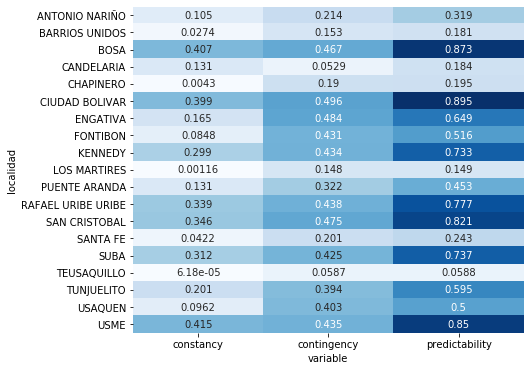

In [41]:
all_predictability_measures(df_agressiveBehavior,lenWindow,crime_level,name_experiment)